In [1]:
%pip install -q rhino3dm shapely trimesh matplotlib pyvista pandas
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
print (df_beams ,df_columns, df_nodes)

NameError: name 'df_beams' is not defined

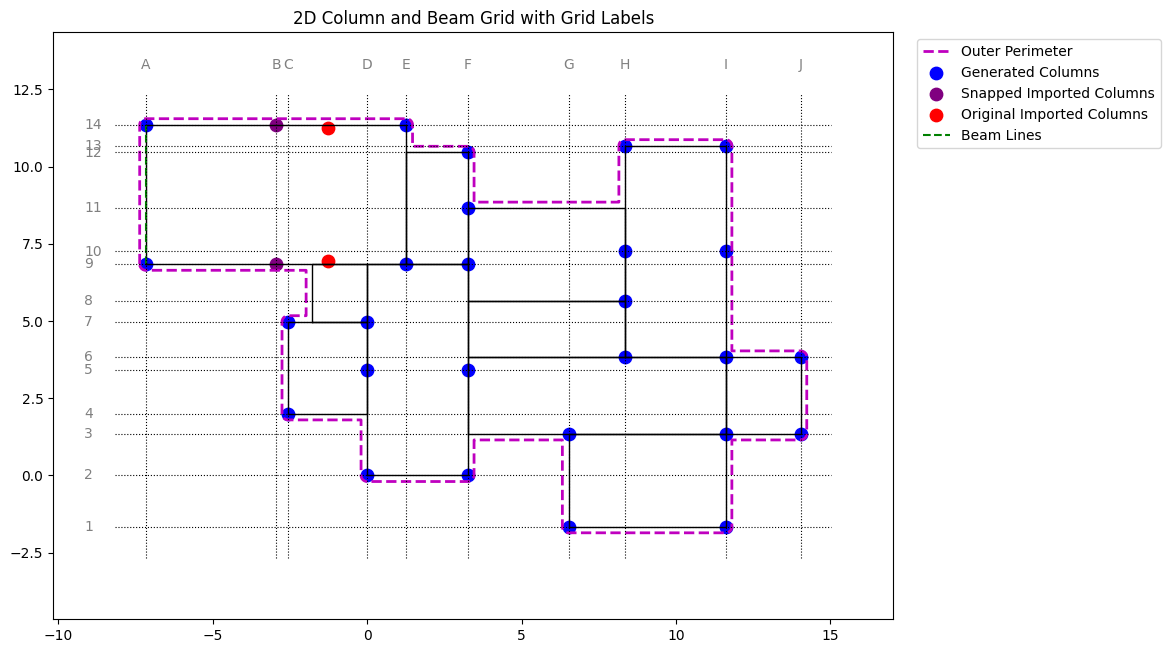


COLUMN SLENDERNESS CHECK (L/r):
  Column C0: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C1: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C2: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C3: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C4: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C5: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C6: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C7: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C8: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C9: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C10: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C11: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C12: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C13: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C14: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C15: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C16: L=118.11 in, r=1.28 in → L/r=92.5 (PASS)
  Column C17: L=118.11 in, r=1.28 in → L/r

In [3]:
# ─────────────────────────────────────────────────────────────
# STEP 1: IMPORT LIBRARIES
# ─────────────────────────────────────────────────────────────
import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import pyvista as pv
import os

# ─────────────────────────────────────────────────────────────
# STEP 2: LOAD RHINO MODEL
# ─────────────────────────────────────────────────────────────
rhino_path = r"../Reference Files/rectangles3dcantileverarchitectural.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}

if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")
column_layer = 'columns' if 'columns' in layers else 'column'

# ─────────────────────────────────────────────────────────────
# STEP 3: EXTRACT GEOMETRY FROM LAYERS
# ─────────────────────────────────────────────────────────────
building_volumes, imported_columns, wall_breps = [], [], []
max_z = 0.0

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [[bbox.Min.X, bbox.Min.Y], [bbox.Max.X, bbox.Min.Y],
                    [bbox.Max.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y], [bbox.Min.X, bbox.Max.Y]]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z)

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# ─────────────────────────────────────────────────────────────
# STEP 4: ASK FOR INPUTS
# ─────────────────────────────────────────────────────────────
num_floors = int(input("Enter number of floors: "))
wall_thickness = float(input("Enter wall thickness: "))

# ─────────────────────────────────────────────────────────────
# STEP 5: BUFFER OUTER PERIMETER
# ─────────────────────────────────────────────────────────────
combined_building_polygon = MultiPolygon(building_volumes)
exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1)
if exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)
perimeter_line_coords = list(exterior_perimeter.exterior.coords) if exterior_perimeter.geom_type == 'Polygon' else []

# ─────────────────────────────────────────────────────────────
# STEP 6: PLACE STRUCTURAL COLUMNS + BEAMS
# ─────────────────────────────────────────────────────────────
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])
MaxS, MinS = 6.0, 3.0
columns, corrected_columns, beams = [], [], []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    x_points = np.linspace(minx, maxx, int(np.ceil((maxx - minx) / MaxS)) + 1)
    y_points = np.linspace(miny, maxy, int(np.ceil((maxy - miny) / MaxS)) + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# ─────────────────────────────────────────────────────────────
# STEP 7: PLOT STRUCTURAL GRID IN 2D
# ─────────────────────────────────────────────────────────────
all_base_columns = columns + corrected_columns
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))
x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

col_min_x_extent = min(grid_xs) - 1.0
col_max_x_extent = max(grid_xs) + 1.0
col_min_y_extent = min(grid_ys) - 1.0
col_max_y_extent = max(grid_ys) + 1.0

min_x_plot = min(col_min_x_extent, min([pt[0] for pt in perimeter_line_coords])) - 2
max_x_plot = max(col_max_x_extent, max([pt[0] for pt in perimeter_line_coords])) + 2
min_y_plot = min(col_min_y_extent, min([pt[1] for pt in perimeter_line_coords])) - 2
max_y_plot = max(col_max_y_extent, max([pt[1] for pt in perimeter_line_coords])) + 2

fig, ax = plt.subplots(figsize=(12, 10))
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter')
if columns:
    gx, gy = zip(*columns)
    ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns')
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns')
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns')
if beams:
    bx1, by1 = beams[0][0]
    bx2, by2 = beams[0][1]
    ax.plot([bx1, bx2], [by1, by2], 'g--', linewidth=1.5, label='Beam Lines')

for x in grid_xs:
    ax.plot([x, x], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8)
    ax.text(x, col_max_y_extent + 0.8, x_grid_labels[x], ha='center', fontsize=10, color='gray')
for y in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y, y], 'k:', linewidth=0.8)
    ax.text(col_min_x_extent - 1.0, y, y_grid_labels[y], va='center', fontsize=10, color='gray')

ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title("2D Column and Beam Grid with Grid Labels")
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()



# ─────────────────────────────────────────────────────────────────
# 1) IMPORTS
# ─────────────────────────────────────────────────────────────────
from Pynite.Visualization import Renderer
from Pynite.FEModel3D import FEModel3D
import pandas as pd
import numpy as np


# ─────────────────────────────────────────────────────────────────
# 3) INITIALIZE A NEW FINITE‐ELEMENT MODEL
# ─────────────────────────────────────────────────────────────────
model = FEModel3D()

# ─────────────────────────────────────────────────────────────────
# 4) ADD NODES TO THE MODEL
# ─────────────────────────────────────────────────────────────────
# Convert meters → inches
UNIT_CONVERSION = 39.37  # meters to inches

for _, row in nodes_df.iterrows():
    nid = str(row['ID'])
    model.add_node(
        nid,
        row['X'] * UNIT_CONVERSION,
        row['Y'] * UNIT_CONVERSION,
        row['Z'] * UNIT_CONVERSION
    )


# ─────────────────────────────────────────────────────────────────
# 5) DEFINE MATERIAL & SECTION (RCC)
# ─────────────────────────────────────────────────────────────────
f_c   = 4.0                           # concrete compressive strength (ksi)
E_c   = 57000 * (f_c ** 0.5)         # elastic modulus (ksi)
G_c   = E_c / (2 * (1 + 0.2))        # shear modulus (ksi), ν≈0.2
rho_c = (150 / 1728) * 1e-3          # density (kip/in³)

model.add_material('RCC', E_c, G_c, f_c, rho_c)

# Section geometry (all members use W14X30 here)
A, Iy, Iz, J = 8.84, 49.0, 14.4, 0.95
model.add_section('W14X30', A, Iy, Iz, J)

# ─────────────────────────────────────────────────────────────────
# 6) ADD MEMBERS (BEAMS + COLUMNS)
# ─────────────────────────────────────────────────────────────────
for _, row in beams_df.iterrows():
    bid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(bid, iN, jN, 'RCC', 'W14X30')

for _, row in columns_df.iterrows():
    cid = str(row['ID'])
    iN  = str(row['i_node'])
    jN  = str(row['j_node'])
    model.add_member(cid, iN, jN, 'RCC', 'W14X30')

# ─────────────────────────────────────────────────────────────────
# 7) DEFINE SUPPORTS (Z=0 nodes fully fixed)
# ─────────────────────────────────────────────────────────────────
for _, row in nodes_df.iterrows():
    fixed = (row['Z'] == 0)
    model.def_support(
        str(row['ID']),
        fixed, fixed, fixed,   # Tx, Ty, Tz
        fixed, fixed, fixed    # Rx, Ry, Rz
    )

# ─────────────────────────────────────────────────────────────────
# 8) COMPUTE MEMBER LENGTHS
# ─────────────────────────────────────────────────────────────────
beam_lengths   = {}
column_lengths = {}

for _, row in beams_df.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    beam_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

for _, row in columns_df.iterrows():
    mid = str(row['ID'])
    iN, jN = str(row['i_node']), str(row['j_node'])
    xi, yi, zi = model.nodes[iN].X, model.nodes[iN].Y, model.nodes[iN].Z
    xj, yj, zj = model.nodes[jN].X, model.nodes[jN].Y, model.nodes[jN].Z
    column_lengths[mid] = float(np.sqrt((xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2))

# ─────────────────────────────────────────────────────────────────
# 9–10) APPLY EQUIVALENT DISTRIBUTED LOADS FOR DL & LL
# ─────────────────────────────────────────────────────────────────
length_lookup = {**beam_lengths, **column_lengths}

for mid in model.members:
    if mid not in length_lookup:
        raise KeyError(f"No length for member '{mid}'")
    L = length_lookup[mid]

    # Dead/Live intensities (kN/m)
    if mid in beam_lengths:
        w_DL, w_LL = -0.02, -0.015    # beams
    else:
        w_DL, w_LL = -0.01, -0.008    # columns

    # Apply distributed loads across full member length
    model.add_member_dist_load(mid, 'FZ', w_DL, w_DL, 0, L, case='DL')
    model.add_member_dist_load(mid, 'FZ', w_LL, w_LL, 0, L, case='LL')

# ─────────────────────────────────────────────────────────────────
# 10.5) APPLY LATERAL NODE LOAD (“W”)
# ─────────────────────────────────────────────────────────────────
# for nid in model.nodes:
#     model.add_node_load(nid, 'FY', -25, case='W')

# ─────────────────────────────────────────────────────────────────
# 11) DEFINE LOAD COMBINATIONS
# ─────────────────────────────────────────────────────────────────
model.add_load_combo('0.9DL+1.0W', factors={'DL': 1.2, 'W': 1.0})
model.add_load_combo('1.2DL+1.0W', factors={'DL': 0.9, 'W': 1.0})

# ─────────────────────────────────────────────────────────────────
# 12) RUN YOUR ANALYSIS
# ─────────────────────────────────────────────────────────────────
model.analyze()

# ─────────────────────────────────────────────────────────────────
# 12.5) VISUALIZE DEFORMED SHAPE
# ─────────────────────────────────────────────────────────────────
rndr = Renderer(model)
rndr.annotation_size = 1.3
rndr.deformed_shape   = True
rndr.deformed_scale   = 50
rndr.combo_name       = '1.2DL+1.0W'
rndr.show_loads       = True
rndr.show_reactions   = True
rndr.window_width     = 750
rndr.window_height    = 750
rndr.render_model()

# ─────────────────────────────────────────────────────────────────
# 13) COLUMN SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_col = 200.0
print("\nCOLUMN SLENDERNESS CHECK (L/r):")
for _, row in columns_df.iterrows():
    cid = str(row['ID'])
    L   = column_lengths[cid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_col else "FAIL"
    print(f"  Column {cid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 14) BEAM SLENDERNESS CHECK (L/r)
# ─────────────────────────────────────────────────────────────────
slenderness_limit_beam = 300.0
print("\nBEAM SLENDERNESS CHECK (L/r):")
for _, row in beams_df.iterrows():
    bid = str(row['ID'])
    L   = beam_lengths[bid]
    sec = model.sections['W14X30']
    r_y = np.sqrt(sec.Iy / sec.A)
    r_z = np.sqrt(sec.Iz / sec.A)
    r   = min(r_y, r_z)
    sl  = L / r
    status = "PASS" if sl <= slenderness_limit_beam else "FAIL"
    print(f"  Beam   {bid}: L={L:.2f} in, r={r:.2f} in → L/r={sl:.1f} ({status})")

# ─────────────────────────────────────────────────────────────────
# 15) PRINT GLOBAL STIFFNESS MATRIX & NODAL DISPLACEMENTS
# ─────────────────────────────────────────────────────────────────
K_sparse = model.K(combo_name='1.2DL+1.0W', log=True, check_stability=True, sparse=True)
K_dense  = K_sparse.toarray()
print("\nGlobal Stiffness Matrix [K] (size {}×{}):".format(*K_dense.shape))
labels = [f"{nid}_{dof}" for nid in model.nodes for dof in ('DX','DY','DZ','RX','RY','RZ')]
K_df = pd.DataFrame(K_dense, index=labels, columns=labels)
print(K_df)

print("\nNODAL DISPLACEMENTS (1.2DL+1.0W):")
for nid, node in model.nodes.items():
    dx = node.DX.get('1.2DL+1.0W', 0.0)
    dy = node.DY.get('1.2DL+1.0W', 0.0)
    dz = node.DZ.get('1.2DL+1.0W', 0.0)
    print(f"  Node {nid}: DX={dx:.6e} in, DY={dy:.6e} in, DZ={dz:.6e} in")



In [14]:
for nid, node in model.nodes.items():
    print(f"{nid}: DX={node.DX['1.2DL+1.0W']:.6e}, DY={node.DY['1.2DL+1.0W']:.6e}, DZ={node.DZ['1.2DL+1.0W']:.6e}")


N0: DX=0.000000e+00, DY=0.000000e+00, DZ=0.000000e+00
N1: DX=-6.745606e-04, DY=1.812104e-04, DZ=-8.029179e-04
N2: DX=-1.708305e-03, DY=5.749841e-04, DZ=-1.471617e-03
N3: DX=-2.983934e-03, DY=8.860360e-04, DZ=-2.004925e-03
N4: DX=-4.314302e-03, DY=1.160348e-03, DZ=-2.402369e-03
N5: DX=-5.618791e-03, DY=1.279931e-03, DZ=-2.663636e-03
N6: DX=-6.021925e-03, DY=1.556010e-03, DZ=-2.788760e-03
N7: DX=0.000000e+00, DY=0.000000e+00, DZ=0.000000e+00
N8: DX=-2.090416e-04, DY=2.663284e-04, DZ=-8.013674e-04
N9: DX=-4.307256e-04, DY=5.578186e-04, DZ=-1.468182e-03
N10: DX=-7.592778e-04, DY=8.923780e-04, DZ=-1.999856e-03
N11: DX=-1.091959e-03, DY=1.141446e-03, DZ=-2.396298e-03
N12: DX=-1.485607e-03, DY=1.378636e-03, DZ=-2.657512e-03
N13: DX=-1.416594e-03, DY=1.284889e-03, DZ=-2.783431e-03
N14: DX=0.000000e+00, DY=0.000000e+00, DZ=0.000000e+00
N15: DX=-5.581822e-04, DY=1.042371e-04, DZ=-2.138469e-03
N16: DX=-1.706724e-03, DY=8.111172e-04, DZ=-3.912903e-03
N17: DX=-2.980372e-03, DY=1.614101e-03, DZ=-5.3

In [29]:
import json

deformed_nodes = []
SCALE = 50  # same as `rndr.deformed_scale` in Renderer()

for nid, node in model.nodes.items():
    dx = node.DX.get('1.2DL+1.0W', 0.0)
    dy = node.DY.get('1.2DL+1.0W', 0.0)
    dz = node.DZ.get('1.2DL+1.0W', 0.0)

    deformed_nodes.append({
        "id": nid,
        "original": {
            "x": node.X,
            "y": node.Y,
            "z": node.Z
        },
        "deformed": {
            "x": node.X + dx * SCALE,
            "y": node.Y + dy * SCALE,
            "z": node.Z + dz * SCALE
        },
        "dx": dx,
        "dy": dy,
        "dz": dz
    })

with open("deformed_nodes.json", "w") as f:
    json.dump(deformed_nodes, f, indent=2)

# At last, print the JSON structure
print(json.dumps(deformed_nodes, indent=2))


[
  {
    "id": "N0",
    "original": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 0.0
    },
    "deformed": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 0.0
    },
    "dx": 0.0,
    "dy": 0.0,
    "dz": 0.0
  },
  {
    "id": "N1",
    "original": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 118.10999999999999
    },
    "deformed": {
      "x": -282.39745269625735,
      "y": 269.4021665432545,
      "z": 118.06593911411568
    },
    "dx": -0.0017162519251479062,
    "dy": 0.0009911128650903055,
    "dz": -0.0008812177176862619
  },
  {
    "id": "N2",
    "original": {
      "x": -282.3116401,
      "y": 269.3526109,
      "z": 236.21999999999997
    },
    "deformed": {
      "x": -282.5142520344761,
      "y": 269.44652179685477,
      "z": 236.15569745192806
    },
    "dx": -0.004052238689522011,
    "dy": 0.001878217937095186,
    "dz": -0.0012860509614379548
  },
  {
    "id": "N3",
    "original": {
      "x": -282.3116401

In [31]:
import json

SCALE = 50  # match your Renderer scale

deformed_members = []

for mid, member in model.members.items():
    i_node = model.nodes[member.i_node]
    j_node = model.nodes[member.j_node]

    # Original coordinates
    xi, yi, zi = i_node.X, i_node.Y, i_node.Z
    xj, yj, zj = j_node.X, j_node.Y, j_node.Z

    # Displacements (use .get() for safety)
    dxi = i_node.DX.get('1.2DL+1.0W', 0.0)
    dyi = i_node.DY.get('1.2DL+1.0W', 0.0)
    dzi = i_node.DZ.get('1.2DL+1.0W', 0.0)

    dxj = j_node.DX.get('1.2DL+1.0W', 0.0)
    dyj = j_node.DY.get('1.2DL+1.0W', 0.0)
    dzj = j_node.DZ.get('1.2DL+1.0W', 0.0)

    deformed_members.append({
        "id": mid,
        "original": {
            "start": {"x": xi, "y": yi, "z": zi},
            "end":   {"x": xj, "y": yj, "z": zj}
        },
        "deformed": {
            "start": {
                "x": xi + dxi * SCALE,
                "y": yi + dyi * SCALE,
                "z": zi + dzi * SCALE
            },
            "end": {
                "x": xj + dxj * SCALE,
                "y": yj + dyj * SCALE,
                "z": zj + dzj * SCALE
            }
        }
    })

with open("deformed_members.json", "w") as f:
    json.dump(deformed_members, f, indent=2)


KeyError: <Pynite.Node3D.Node3D object at 0x000001FA113237D0>